In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-course-data/ion.csv
/kaggle/input/dl-course-data/spotify.csv
/kaggle/input/dl-course-data/forestfires.csv
/kaggle/input/dl-course-data/songs.csv
/kaggle/input/dl-course-data/abalone.csv
/kaggle/input/dl-course-data/concrete.csv
/kaggle/input/dl-course-data/fuel.csv
/kaggle/input/dl-course-data/red-wine.csv
/kaggle/input/dl-course-data/hotel.csv
/kaggle/input/dl-course-data/diamonds.csv
/kaggle/input/dl-course-data/candy.csv
/kaggle/input/dl-course-data/cereal.csv
/kaggle/input/dl-course-data/housing.csv


## Import required library, and datasets

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers


fuel = pd.read_csv('../input/dl-course-data/fuel.csv')
fuel.head()

,EngDispl,NumCyl,Transmission,FE,AirAspirationMethod,NumGears,TransLockup,TransCreeperGear,DriveDesc,IntakeValvePerCyl,ExhaustValvesPerCyl,CarlineClassDesc,VarValveTiming,VarValveLift
0,4.7,8,AM6,28.0198,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
1,4.7,8,M6,25.6094,NaturallyAspirated,6,1,0,TwoWheelDriveRear,2,2,2Seaters,1,0
2,4.2,8,M6,26.8000,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
3,4.2,8,AM6,25.0451,NaturallyAspirated,6,1,0,AllWheelDrive,2,2,2Seaters,1,0
4,5.2,10,AM6,24.8000,NaturallyAspirated,6,0,0,AllWheelDrive,2,2,2Seaters,1,0


In [3]:
fuel.describe()

,EngDispl,NumCyl,FE,NumGears,TransLockup,TransCreeperGear,IntakeValvePerCyl,ExhaustValvesPerCyl,VarValveTiming,VarValveLift
count,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000
mean,3.507407,5.971093,34.706489,5.268293,0.680217,0.048780,1.861789,1.837398,0.822945,0.167118
std,1.305905,1.900575,7.498033,1.396624,0.466603,0.215506,0.353046,0.374035,0.381888,0.373250
min,1.000000,2.000000,17.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.400000,4.000000,29.085350,5.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000
50%,3.500000,6.000000,34.514800,6.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000
75%,4.300000,8.000000,39.200000,6.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000
max,8.400000,16.000000,69.640400,8.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000


## initial PDA and data cleaning

In [4]:
df = fuel.copy()
y = df.pop('FE')

df_train = df.sample(frac=0.7, random_state=1)
df_valid = df.drop(df_train.index)
y_train = y.sample(frac=0.7, random_state=1)
y_valid = y.drop(df_train.index)

df_train.dropna(axis=1, inplace=True)  # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(df_train)
y = np.log(y) # log transform target instead of standardizing

X_train = preprocessor.fit_transform(df_train)
X_valid = preprocessor.fit_transform(df_valid)
y_train = np.log(y_train)
y_valid = np.log(y_valid)


input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


## Creating the model 

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

2022-07-22 13:13:21.701795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Initilizing hyperparameters and callback functions

In [6]:
model.compile(
    optimizer= 'adam',
    loss='mae',
    metrics=['mae']
)

## Checking the model structure and size

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
_________________________________________________________________


## Fitting the model 

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,  # hide the output because we have so many epochs
)

2022-07-22 13:13:21.973910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Visulizing the model paramaters, and ploting loss and accuracy 

Minimum validation loss: 0.08198601007461548


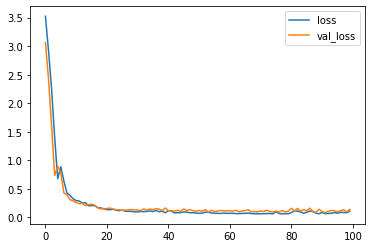

In [9]:
# Show the learning curves
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))